### Build CNN Conditional GAN to generate synthetic cifar 10 data
Proposed Conditional GAN label embedding: embed labels to generator, add classification head to discriminator

In [89]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim
import torch.nn.functional as F

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [91]:
training_parameters = {
    "n_epochs": 100,
    "batch_size": 100,
}
data_loader = torch.utils.data.DataLoader(
  
datasets.MNIST('./', train=True, download=True,
                         transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(
                             (0.5,), (0.5,))
                         ])),
batch_size=training_parameters["batch_size"], shuffle=True)

torch.Size([100, 1, 28, 28])


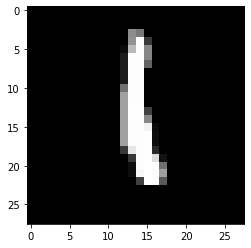

In [92]:
%matplotlib inline 
from matplotlib import pyplot as plt

for x,_ in data_loader:
    print(x.shape)
    plt.imshow(x.numpy()[0][0], cmap='gray')
    break

tensor([6, 1, 3, 7, 9, 4, 3, 7, 2, 3, 1, 2, 0, 5, 0, 4, 2, 9, 6, 7, 6, 8, 6, 5,
        2, 7, 6, 6, 4, 9, 2, 1, 2, 0, 0, 7, 5, 5, 7, 0, 0, 3, 2, 6, 6, 7, 8, 8,
        4, 3, 3, 7, 6, 0, 7, 5, 6, 1, 0, 8, 3, 6, 4, 4, 9, 9, 9, 9, 8, 0, 8, 6,
        7, 1, 7, 0, 3, 9, 5, 4, 5, 5, 9, 9, 4, 2, 1, 2, 6, 8, 9, 0, 9, 2, 9, 0,
        4, 6, 0, 9])


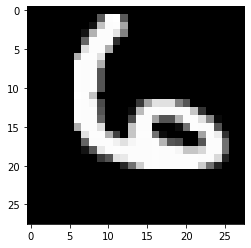

In [103]:
for x, label in data_loader:
    print(label)
    plt.imshow(x.numpy()[0][0], cmap='gray')
    break

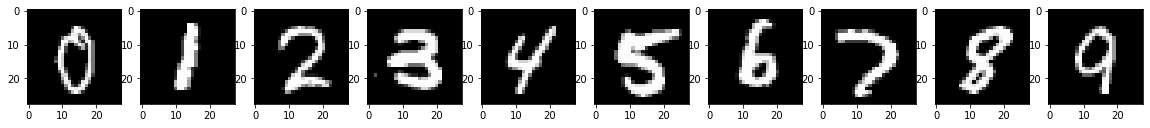

In [107]:
count = 0
fig, axs = plt.subplots(1, 10, figsize=(20,2))
for i, l in enumerate(label):
    if l == count:
        axs[count].imshow(x.numpy()[i][0], interpolation='nearest',cmap='gray')
        count += 1
    if count == 10:
        break
fig.savefig(f'mnist_real.pdf')

In [93]:
class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        image_size = 28
        latent_dim = 100
        output_channels = 1
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        self.label_embedding = nn.Embedding(10, 10)
        self.l2 = nn.Linear(10, self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(129),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(129, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, output_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
# #         print(z.shape)
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) # bh, 128, 8, 8
# #         print(out.shape)
        
        li = self.label_embedding(labels)
# #         print(li.shape)
        li = self.l2(li)
# #         print(li.shape)
        li = li.view(labels.shape[0], 1, self.init_size, self.init_size)
# #         print(li.shape)
        out = torch.cat([out, li], 1)
# #         print(out.shape)
        
        img = self.conv_blocks(out)
# #         print(img.shape)
        return img
'''
z shape torch.Size([100, 100])
z shape after view torch.Size([100, 128, 7, 7])
label embedding shape torch.Size([100, 10])
label embedding after l2 torch.Size([100, 49])
label embedding after view torch.Size([100, 1, 7, 7])
concatenate z and label embedding torch.Size([100, 129, 7, 7])
after convolution layers torch.Size([100, 1, 28, 28])
'''

'\nz shape torch.Size([100, 100])\nz shape after view torch.Size([100, 128, 7, 7])\nlabel embedding shape torch.Size([100, 10])\nlabel embedding after l2 torch.Size([100, 49])\nlabel embedding after view torch.Size([100, 1, 7, 7])\nconcatenate z and label embedding torch.Size([100, 129, 7, 7])\nafter convolution layers torch.Size([100, 1, 28, 28])\n'

In [94]:
class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.image_size = 28
        self.output_channels = 1
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(self.output_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        # The height and width of downsampled image
        ds_size = self.image_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
        self.cls_layer = nn.Linear(512, 10)

    def forward(self, img):
        
        out = self.model(img)
#         print(out.shape)
        out = out.view(out.shape[0], -1)
#         print(out.shape)
        out_adv = self.adv_layer(out)
        out_cls = self.cls_layer(out)
#         print(f'out_adv.shape {out_adv.shape}')  # [100, 1]
#         print(f'out_cls.shape {out_cls.shape}')  # [100, 10]
#         print(validity)

        return out_adv, out_cls

'''
image shape torch.Size([100, 1, 28, 28])
label embedding after l1 shape torch.Size([100, 784])
label embedding after reshape torch.Size([100, 1, 28, 28])
concatenate image and label embedding torch.Size([100, 2, 28, 28])
feature map size after convolution layers torch.Size([100, 128, 2, 2])
feature map to dense layer torch.Size([100, 512])
'''

'\nimage shape torch.Size([100, 1, 28, 28])\nlabel embedding after l1 shape torch.Size([100, 784])\nlabel embedding after reshape torch.Size([100, 1, 28, 28])\nconcatenate image and label embedding torch.Size([100, 2, 28, 28])\nfeature map size after convolution layers torch.Size([100, 128, 2, 2])\nfeature map to dense layer torch.Size([100, 512])\n'

In [95]:
discriminator1 = Discriminator1()
generator1 = Generator1()
discriminator1.to(device)
generator1.to(device)

Generator1(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (label_embedding): Embedding(10, 10)
  (l2): Linear(in_features=10, out_features=49, bias=True)
  (conv_blocks): Sequential(
    (0): BatchNorm2d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(129, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [96]:
def train(generator, discriminator, data_loader, model_name="cnn_stargan"):
    n_epochs = 100
    batch_size = 100
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
    generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
    lambda_cls = 1

    adv_criterion = nn.BCELoss()
    cls_criterion = nn.CrossEntropyLoss()
    
    for epoch_idx in range(n_epochs):
        G_loss = []
        D_loss = []
        for batch_idx, data_input in enumerate(data_loader):


            noise = torch.randn(batch_size,100).to(device)
            fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
#             print(f'fake_labels shape {fake_labels.shape}') # [100]
            generated_data = generator(noise, fake_labels)


            # Discriminator
            true_data = data_input[0].to(device)
            digit_labels = data_input[1].to(device) # batch_size
#             print(f'digit_labels shape {digit_labels.shape}') # [100]
#             true_labels = torch.ones(batch_size).to(device)

            discriminator_optimizer.zero_grad()

            r_out_adv, r_out_cls = discriminator(true_data)
            r_adv_loss = adv_criterion(r_out_adv.view(batch_size), torch.ones(batch_size).to(device))
            r_cls_loss = cls_criterion(r_out_cls, digit_labels)

            f_out_adv, f_out_cls = discriminator(generated_data.detach())
            f_adv_loss = adv_criterion(f_out_adv.view(batch_size), torch.zeros(batch_size).to(device))
            d_loss = r_adv_loss + f_adv_loss + lambda_cls * r_cls_loss

            d_loss.backward()
            discriminator_optimizer.step()

            D_loss.append(d_loss.data.item())


            # Generator

            generator_optimizer.zero_grad()
            # It's a choice to generate the data again
            generated_data = generator(noise, fake_labels)
            g_out_adv, g_out_cls = discriminator(generated_data)
            g_adv_loss = adv_criterion(g_out_adv.view(batch_size), torch.ones(batch_size).to(device))
            g_cls_loss = cls_criterion(g_out_cls, fake_labels)
            g_loss = g_adv_loss + lambda_cls * g_cls_loss
            g_loss.backward()
            generator_optimizer.step()
            
            G_loss.append(g_loss.data.item())
            
            
            if ((batch_idx + 1)% 500 == 0 and (epoch_idx + 1)%10 == 0):
                print("Training Steps Completed: ", batch_idx)

                with torch.no_grad():
                    noise = torch.randn(batch_size,100).to(device)
                    fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                    generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)
                    for x in generated_data:
                        print(fake_labels[0].item())
                        plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
                        plt.show()
                        break


        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
        torch.save(generator, f'./{model_name}.pt')

[0/100]: loss_d: 1.974, loss_g: 2.102
[1/100]: loss_d: 1.426, loss_g: 1.427
[2/100]: loss_d: 1.386, loss_g: 1.283
[3/100]: loss_d: 1.297, loss_g: 1.296
[4/100]: loss_d: 1.268, loss_g: 1.275
[5/100]: loss_d: 1.269, loss_g: 1.225
[6/100]: loss_d: 1.279, loss_g: 1.144
[7/100]: loss_d: 1.307, loss_g: 1.105
[8/100]: loss_d: 1.326, loss_g: 1.087
Training Steps Completed:  499
1


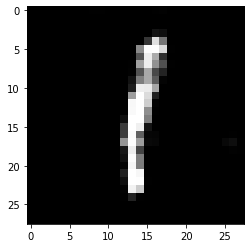

[9/100]: loss_d: 1.335, loss_g: 1.048
[10/100]: loss_d: 1.353, loss_g: 1.024
[11/100]: loss_d: 1.344, loss_g: 0.995
[12/100]: loss_d: 1.363, loss_g: 0.987
[13/100]: loss_d: 1.372, loss_g: 0.973
[14/100]: loss_d: 1.368, loss_g: 0.951
[15/100]: loss_d: 1.388, loss_g: 0.933
[16/100]: loss_d: 1.380, loss_g: 0.917
[17/100]: loss_d: 1.384, loss_g: 0.910
[18/100]: loss_d: 1.384, loss_g: 0.909
Training Steps Completed:  499
2


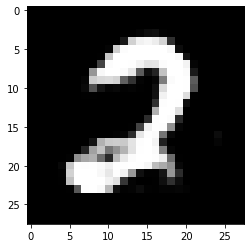

[19/100]: loss_d: 1.379, loss_g: 0.920
[20/100]: loss_d: 1.382, loss_g: 0.898
[21/100]: loss_d: 1.383, loss_g: 0.878
[22/100]: loss_d: 1.398, loss_g: 0.888
[23/100]: loss_d: 1.393, loss_g: 0.886
[24/100]: loss_d: 1.389, loss_g: 0.877
[25/100]: loss_d: 1.411, loss_g: 0.866
[26/100]: loss_d: 1.397, loss_g: 0.861
[27/100]: loss_d: 1.404, loss_g: 0.850
[28/100]: loss_d: 1.406, loss_g: 0.842
Training Steps Completed:  499
5


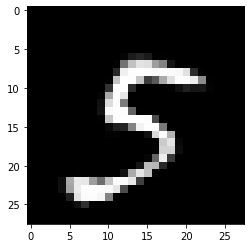

[29/100]: loss_d: 1.390, loss_g: 0.852
[30/100]: loss_d: 1.398, loss_g: 0.856
[31/100]: loss_d: 1.398, loss_g: 0.859
[32/100]: loss_d: 1.407, loss_g: 0.848
[33/100]: loss_d: 1.378, loss_g: 0.854
[34/100]: loss_d: 1.401, loss_g: 0.844
[35/100]: loss_d: 1.378, loss_g: 0.847
[36/100]: loss_d: 1.394, loss_g: 0.862
[37/100]: loss_d: 1.397, loss_g: 0.858
[38/100]: loss_d: 1.395, loss_g: 0.834
Training Steps Completed:  499
6


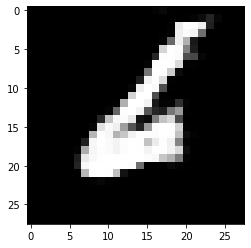

[39/100]: loss_d: 1.374, loss_g: 0.851
[40/100]: loss_d: 1.358, loss_g: 0.847
[41/100]: loss_d: 1.381, loss_g: 0.863
[42/100]: loss_d: 1.382, loss_g: 0.851
[43/100]: loss_d: 1.383, loss_g: 0.844
[44/100]: loss_d: 1.366, loss_g: 0.853
[45/100]: loss_d: 1.385, loss_g: 0.855
[46/100]: loss_d: 1.373, loss_g: 0.849
[47/100]: loss_d: 1.376, loss_g: 0.848
[48/100]: loss_d: 1.375, loss_g: 0.846
Training Steps Completed:  499
0


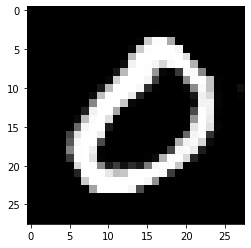

[49/100]: loss_d: 1.368, loss_g: 0.854
[50/100]: loss_d: 1.364, loss_g: 0.862
[51/100]: loss_d: 1.356, loss_g: 0.859
[52/100]: loss_d: 1.373, loss_g: 0.852
[53/100]: loss_d: 1.379, loss_g: 0.851
[54/100]: loss_d: 1.372, loss_g: 0.854
[55/100]: loss_d: 1.363, loss_g: 0.833
[56/100]: loss_d: 1.346, loss_g: 0.860
[57/100]: loss_d: 1.362, loss_g: 0.872
[58/100]: loss_d: 1.349, loss_g: 0.874
Training Steps Completed:  499
8


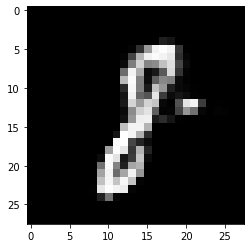

[59/100]: loss_d: 1.355, loss_g: 0.865
[60/100]: loss_d: 1.342, loss_g: 0.875
[61/100]: loss_d: 1.354, loss_g: 0.875
[62/100]: loss_d: 1.358, loss_g: 0.868
[63/100]: loss_d: 1.355, loss_g: 0.871
[64/100]: loss_d: 1.340, loss_g: 0.879
[65/100]: loss_d: 1.339, loss_g: 0.884
[66/100]: loss_d: 1.346, loss_g: 0.873
[67/100]: loss_d: 1.340, loss_g: 0.878
[68/100]: loss_d: 1.335, loss_g: 0.878
Training Steps Completed:  499
0


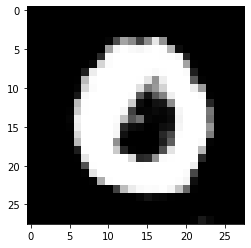

[69/100]: loss_d: 1.340, loss_g: 0.897
[70/100]: loss_d: 1.349, loss_g: 0.877
[71/100]: loss_d: 1.330, loss_g: 0.897
[72/100]: loss_d: 1.327, loss_g: 0.879
[73/100]: loss_d: 1.328, loss_g: 0.880
[74/100]: loss_d: 1.322, loss_g: 0.890
[75/100]: loss_d: 1.349, loss_g: 0.905
[76/100]: loss_d: 1.308, loss_g: 0.901
[77/100]: loss_d: 1.308, loss_g: 0.895
[78/100]: loss_d: 1.326, loss_g: 0.912
Training Steps Completed:  499
6


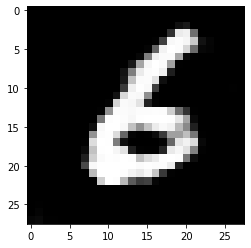

[79/100]: loss_d: 1.329, loss_g: 0.918
[80/100]: loss_d: 1.305, loss_g: 0.902
[81/100]: loss_d: 1.305, loss_g: 0.915
[82/100]: loss_d: 1.305, loss_g: 0.909
[83/100]: loss_d: 1.298, loss_g: 0.932
[84/100]: loss_d: 1.315, loss_g: 0.920
[85/100]: loss_d: 1.289, loss_g: 0.929
[86/100]: loss_d: 1.314, loss_g: 0.913
[87/100]: loss_d: 1.295, loss_g: 0.927
[88/100]: loss_d: 1.299, loss_g: 0.931
Training Steps Completed:  499
5


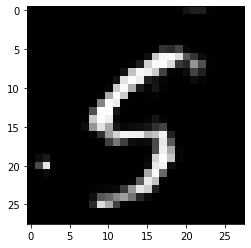

[89/100]: loss_d: 1.296, loss_g: 0.968
[90/100]: loss_d: 1.308, loss_g: 0.929
[91/100]: loss_d: 1.291, loss_g: 0.955
[92/100]: loss_d: 1.297, loss_g: 0.966
[93/100]: loss_d: 1.295, loss_g: 0.957
[94/100]: loss_d: 1.280, loss_g: 0.967
[95/100]: loss_d: 1.286, loss_g: 0.951
[96/100]: loss_d: 1.280, loss_g: 0.942
[97/100]: loss_d: 1.267, loss_g: 0.946
[98/100]: loss_d: 1.288, loss_g: 0.974
Training Steps Completed:  499
0


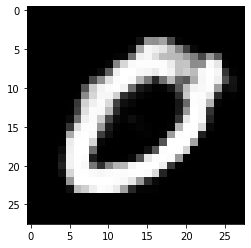

[99/100]: loss_d: 1.273, loss_g: 0.962


In [97]:
train(generator1, discriminator1, data_loader)

1


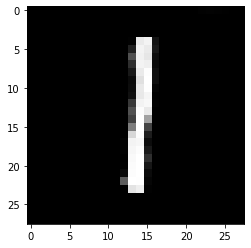

3


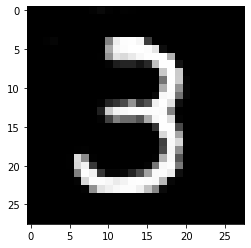

0


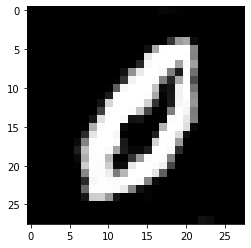

8


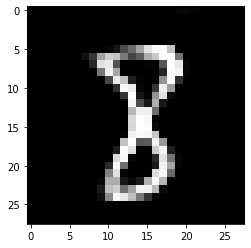

3


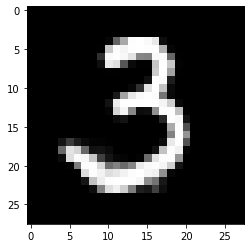

0


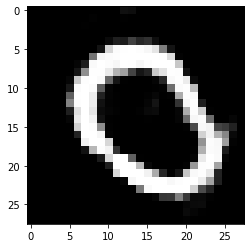

5


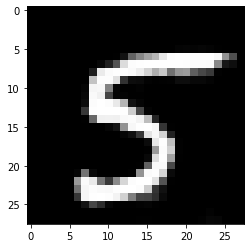

0


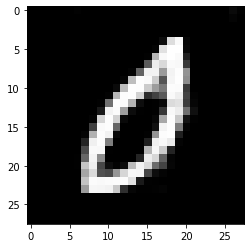

2


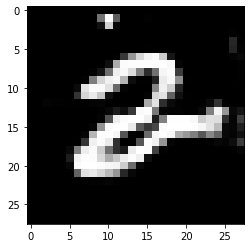

0


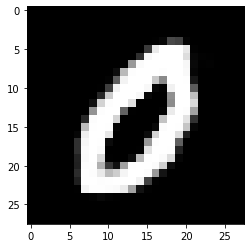

In [98]:
with torch.no_grad():
    noise = torch.randn(10,100).to(device)
    fake_labels = torch.randint(0, 10, (10,)).to(device)
    generated_data = generator1(noise, fake_labels).cpu().view(10, 28, 28)
    for i, x in enumerate(generated_data):
        print(fake_labels[i].item())
        plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
        plt.show()

In [99]:
#load model and generate 0 - 9 images
def draw_images(model_name):
    generator = torch.load(model_name)
    with torch.no_grad():
        noise = torch.randn(10,100).to(device)
        labels = torch.IntTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
#         labels = torch.range(0, 9)
        generated_data = generator(noise, labels).cpu().view(10, 28, 28)

    fig, axs = plt.subplots(1, 10, figsize=(20,2))
    for i in range(10):
        axs[i].imshow(generated_data[i].detach().numpy(), interpolation='nearest',cmap='gray')
    fig.savefig(f'{model_name}_syn.pdf')

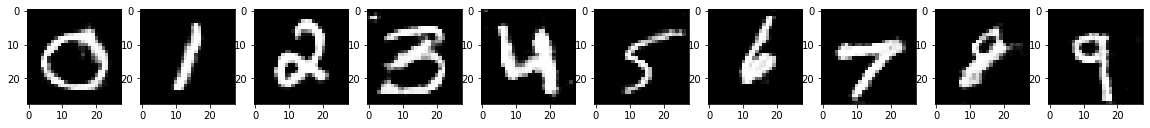

In [100]:
draw_images('cnn_cgan.pt')